In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from PIL import Image
import seaborn as sn
import pandas as pd
from torchvision.transforms import ToTensor, Normalize, Compose
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline


In [2]:
project_name='rock-paper-scissors'

In [3]:
# Data directory
data_dir = './datasets/Datasets/Datasets'
print(os.listdir(data_dir))

# Classes
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'val']
['paper', 'rock', 'scissors']


In [4]:
stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tfms = tt.Compose([tt.CenterCrop(224),
                         tt.Resize((32,32)), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.CenterCrop(224),tt.Resize((32,32)),tt.ToTensor(), tt.Normalize(*stats)])


In [5]:
# Datasets
train_dataset = ImageFolder(data_dir+'/train', train_tfms)
valid_dataset = ImageFolder(data_dir+'/val', valid_tfms)
test_dataset = ImageFolder(data_dir+'/test', valid_tfms)

In [6]:
batch_size = 64
num_of_classes = len(classes)
num_of_classes

3

In [7]:
#Data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [ ]:
def show_images(dataloader):
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_images(train_dataloader)

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
# Moving Dataset on the device('Cuda' if available)
train_dataloader = DeviceDataLoader(train_dataloader, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class BasicResNet9(nn.Module):
    def __init__(self, in_channels, num_of_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_of_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = self.classifier(out)
        return out

In [ ]:
basicResNetModel = BasicResNet9(3,3)
basicResNetModel

In [25]:
# Define the ResNet9 model
class ResNet9(nn.Module):
    def __init__(self):
        super(ResNet9, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512, 3)
        
        self.fc = nn.Sequential(nn.MaxPool2d(4),
                                nn.Flatten(), 
#                                 nn.Dropout(0.2),
                                nn.Linear(512, num_of_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [12]:
resNet9Model = ResNet9()
resNet9Model

ResNet9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_siz

In [33]:
class SmallResNet9(nn.Module):
    def __init__(self):
        super(SmallResNet9, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(256, num_of_classes)
        
        self.fc = nn.Sequential(nn.MaxPool2d(4), 
                      nn.Flatten(), 
                      nn.Dropout(0.2),
                      nn.Linear(256, num_of_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [13]:
k = 5
number_of_epochs = 40
learning_rate = 0.001
weight_decay = 1e-4

In [14]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [15]:
# Evaluation function
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [42]:
# K-fold cross-validation

kf = KFold(n_splits=k, shuffle=True)

# Initialize lists to store training and validation losses and accuracies


# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    # Define model,
    model = SmallResNet9()
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), learning_rate)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Train and validate for this fold
    for epoch in range(number_of_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
#         val_loss = evaluate(model, val_loader)
        val_loss = train(model,val_loader,criterion,optimizer)
        val_accuracy = evaluate(model, val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
    # Save the model for this fold
#     torch.save(model.state_dict(), f'resnet9_fold{fold}.pt')
    
# Print overall validation accuracy
print(f'Overall validation accuracy: {np.mean(val_accuracies):.4f}')


Fold 1/5
Epoch 1 - Train loss: 0.9170 - Val loss: 1.2948 - Val accuracy: 0.3281
Epoch 2 - Train loss: 0.7825 - Val loss: 1.1810 - Val accuracy: 0.5646
Epoch 3 - Train loss: 0.7033 - Val loss: 1.1367 - Val accuracy: 0.6981
Epoch 4 - Train loss: 0.6666 - Val loss: 1.0669 - Val accuracy: 0.7234
Epoch 5 - Train loss: 0.6474 - Val loss: 1.0323 - Val accuracy: 0.7173
Epoch 6 - Train loss: 0.6379 - Val loss: 0.9692 - Val accuracy: 0.8386
Epoch 7 - Train loss: 0.6260 - Val loss: 0.9543 - Val accuracy: 0.8429
Epoch 8 - Train loss: 0.6201 - Val loss: 0.9038 - Val accuracy: 0.8813
Epoch 9 - Train loss: 0.6108 - Val loss: 0.8665 - Val accuracy: 0.8473
Epoch 10 - Train loss: 0.6059 - Val loss: 0.8391 - Val accuracy: 0.8796
Epoch 11 - Train loss: 0.6046 - Val loss: 0.8103 - Val accuracy: 0.8813
Epoch 12 - Train loss: 0.5988 - Val loss: 0.7934 - Val accuracy: 0.8787
Epoch 13 - Train loss: 0.5963 - Val loss: 0.7853 - Val accuracy: 0.8604
Epoch 14 - Train loss: 0.5967 - Val loss: 0.7737 - Val accuracy:

KeyboardInterrupt: 

In [43]:
# Saving the model
torch.save(model, './saved_model.pth')

In [44]:
# Function to plot the losses
def plot_losses():
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

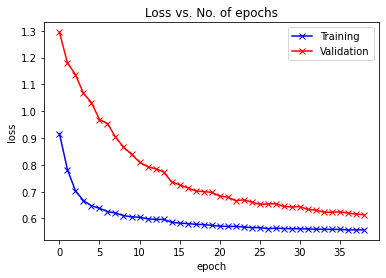

In [45]:
plot_losses()

In [46]:
test_ds = ImageFolder(data_dir+'/test', valid_tfms)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [47]:
# Testing the model
test_model = ResNet9()
PATH = 'saved_model.pth'
test_model = torch.load("saved_model.pth", map_location = device)
test_model.to(device)

SmallResNet9(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size

In [48]:
test_model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dl:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = test_model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the ResNet9 model on the %d test images: %d %%' % (total, 100 * correct / total))

def evaluate_test_data(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = test_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    f1score = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    print('F1 Score:- ', f1score)
    print('Accuracy:- ', accuracy)

In [49]:
evaluate_test_data(test_model,test_dl)

F1 Score:-  0.6895459007900271
Accuracy:-  0.6864035087719298
